In [ ]:
!pip install --upgrade transformers datasets evaluate -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 90.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 503.6/503.6 kB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 22.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible.
cudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible.


In [ ]:
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
from datasets import load_dataset
import numpy as np
import evaluate
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset = load_dataset("bwbayu/automatic_essay_scoring")
print(dataset)
print(dataset["train"].column_names)
print(dataset["train"][:3]["answer"])
print(dataset["train"][:3]["normalized_score"])


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/777 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/2.28M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/699k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/343k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/15682 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/4705 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2019 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['question', 'reference_answer', 'answer', 'score', 'dataset', 'max_length1', 'normalized_score', '__index_level_0__'],
        num_rows: 15682
    })
    validation: Dataset({
        features: ['question', 'reference_answer', 'answer', 'score', 'dataset', 'max_length1', 'normalized_score', '__index_level_0__'],
        num_rows: 4705
    })
    test: Dataset({
        features: ['question', 'reference_answer', 'answer', 'score', 'dataset', 'max_length1', 'normalized_score', '__index_level_0__'],
        num_rows: 2019
    })
})
['question', 'reference_answer', 'answer', 'score', 'dataset', 'max_length1', 'normalized_score', '__index_level_0__']
['membantu meningkatan kecerdasaan otak,membantu memelihara kekebalan tubuh,membantu menambah energy didalam tubuh,dengan berolahraga dapat membantu mencairkan rasa stress,dapat membantu program diet ', 'disiplin, bijaksana, arif, tegas, jujur, ramah, adil, beriman ', '-jangan membawa uang b

In [ ]:
model_name = "indobenchmark/indobert-base-p1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
max_length = 512

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
def preprocess_function(examples):
    texts = [
        f"{q} {tokenizer.sep_token} {r} {tokenizer.sep_token} {a}"
        for q, r, a in zip(examples["question"], examples["reference_answer"], examples["answer"])
    ]
    return tokenizer(
        texts,
        truncation=True,
        padding="max_length",
        max_length=max_length
    )

In [ ]:
def prepare_labels(examples):
    examples["labels"] = examples["normalized_score"]
    return examples

tokenized_dataset = dataset.map(preprocess_function, batched=True)
tokenized_dataset = tokenized_dataset.map(prepare_labels, batched=True)

Map:   0%|          | 0/15682 [00:00<?, ? examples/s]

Map:   0%|          | 0/4705 [00:00<?, ? examples/s]

Map:   0%|          | 0/2019 [00:00<?, ? examples/s]

Map:   0%|          | 0/15682 [00:00<?, ? examples/s]

Map:   0%|          | 0/4705 [00:00<?, ? examples/s]

Map:   0%|          | 0/2019 [00:00<?, ? examples/s]

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=1,
    problem_type="regression"
)

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions.squeeze()

    mae = mean_absolute_error(labels, predictions)
    rmse = root_mean_squared_error(labels, predictions)

    return {"mae": mae, "rmse": rmse}

In [ ]:
training_args = TrainingArguments(
    output_dir="./indobert_essay_scoring",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="rmse",
    greater_is_better=False,
    report_to=[]
)


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

/tmp/ipython-input-991116914.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Mae,Rmse
1,No log,0.053958,0.184065,0.232289
2,0.074800,0.039970,0.146664,0.199926
3,0.045400,0.034477,0.134071,0.185681


TrainOutput(global_step=1473, training_loss=0.05210717324893327, metrics={'train_runtime': 4688.2455, 'train_samples_per_second': 10.035, 'train_steps_per_second': 0.314, 'total_flos': 1.2378211570501632e+16, 'train_loss': 0.05210717324893327, 'epoch': 3.0})

{'eval_loss': 0.034477438777685165, 'eval_mae': 0.1340712159872055, 'eval_rmse': 0.18568101525306702, 'eval_runtime': 140.2629, 'eval_samples_per_second': 33.544, 'eval_steps_per_second': 1.055, 'epoch': 3.0}


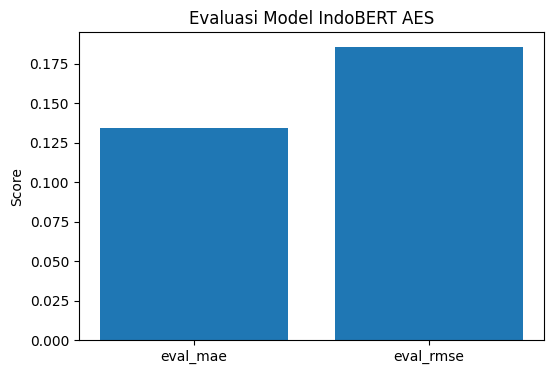

In [ ]:
eval_results = trainer.evaluate()
print(eval_results)

metrics = ["eval_mae", "eval_rmse"]
values = [eval_results[m] for m in metrics]

plt.figure(figsize=(6, 4))
plt.bar(metrics, values)
plt.title("Evaluasi Model IndoBERT AES")
plt.ylabel("Score")
plt.show()

In [ ]:
trainer.save_model("./indobert_essay_scoring")
tokenizer.save_pretrained("./indobert_essay_scoring")

('./indobert_essay_scoring/tokenizer_config.json',
 './indobert_essay_scoring/special_tokens_map.json',
 './indobert_essay_scoring/vocab.txt',
 './indobert_essay_scoring/added_tokens.json',
 './indobert_essay_scoring/tokenizer.json')

In [ ]:
!cp -r ./indobert_essay_scoring /content/drive/MyDrive/

In [ ]:
imported_model = AutoModelForSequenceClassification.from_pretrained("./indobert_essay_scoring")
imported_model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e